In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn import preprocessing


import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, SVGD, RBFSteinKernel, Trace_ELBO, NUTS, MCMC
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import Predictive

import numpy as np

import matplotlib.pyplot as plt

import os

from src.models.TurbulenceNetwork import TurbulenceNetworkBayesian
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

%load_ext autoreload
%autoreload 2

## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:83: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


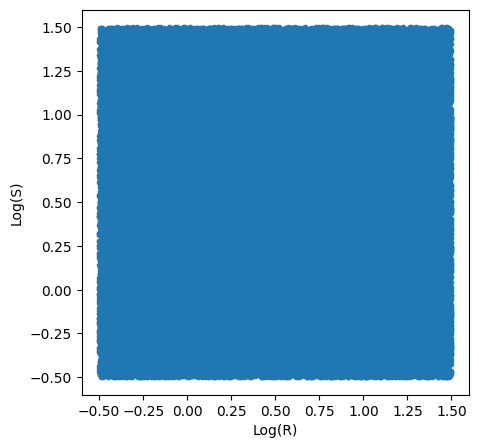

In [2]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 1.5)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Training Parameters

In [3]:
model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "residual_blocks": 1,
    "layer_per_residual": 1,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 5.], device=device),
    "device": device,
    "output_prior": torch.tensor([.05], device=device)
}

In [4]:
model = TurbulenceNetworkBayesian(**model_params).to(device)

display(model)

guide = AutoDiagonalNormal(model)

adam = Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=2))

TurbulenceNetworkBayesian(
  (stem): PyroLinear(in_features=2, out_features=20, bias=True)
  (layers): PyroModuleList(
    (0): BayesianLinearResidualBlock(
      (layers): PyroModuleList(
        (0): BayesianLinearResidual(
          (linear): PyroLinear(in_features=20, out_features=20, bias=True)
          (activation): ReLU()
        )
      )
    )
  )
  (output): PyroLinear(in_features=20, out_features=3, bias=True)
)

## Defining Datasets

In [5]:
x_scaler = preprocessing.StandardScaler().fit(etas_train)
y_scaler = preprocessing.StandardScaler().fit(gs_train)

x_scaled_train = x_scaler.transform(etas_train)
y_scaled_train = y_scaler.transform(gs_train)

x_train = torch.tensor(x_scaled_train, dtype=torch.float32)
y_train = torch.tensor(y_scaled_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=512, shuffle=True)

x_test = torch.tensor(x_scaler.transform(etas_test), dtype=torch.float32).to(device)
y_test = torch.tensor(y_scaler.transform(gs_test), dtype=torch.float32).to(device)

## MCMC Training

In [6]:
pyro.clear_param_store()

n_epochs = 1000

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:20.4f}, Train loss: {loss:20.4f}")

Epoch        0 Test loss:       322558850.5688, Train loss:    182753052123.3551
Epoch        5 Test loss:        23206451.9154, Train loss:      4498053303.1102
Epoch       10 Test loss:        17401005.5683, Train loss:      2837355872.2627
Epoch       15 Test loss:        14887414.2065, Train loss:      1969493373.0322
Epoch       20 Test loss:         5901612.3750, Train loss:      1332406153.0451
Epoch       25 Test loss:        12169390.7997, Train loss:       916942148.0615
Epoch       30 Test loss:         6153821.5388, Train loss:       627459402.5647
Epoch       35 Test loss:         3301959.3546, Train loss:       502371296.4643
Epoch       40 Test loss:         2577174.3789, Train loss:       395816400.0301
Epoch       45 Test loss:         1475139.8687, Train loss:       321027846.6689
Epoch       50 Test loss:         1728644.5393, Train loss:       252027553.4769
Epoch       55 Test loss:         1299124.0886, Train loss:       206072506.2256
Epoch       60 Test loss:   

KeyboardInterrupt: 

In [7]:
save_pyro_model(model, guide, "Model_Checkpoints")

## Loading Trained Model

In [8]:
model = TurbulenceNetworkBayesian(**model_params)

model, guide = load_pyro_model(model, "Model_Checkpoints", device)


parameters = pyro.get_param_store()
model = model.to(device)
guide = guide.to(device)

tensor(0.0094, dtype=torch.float64)


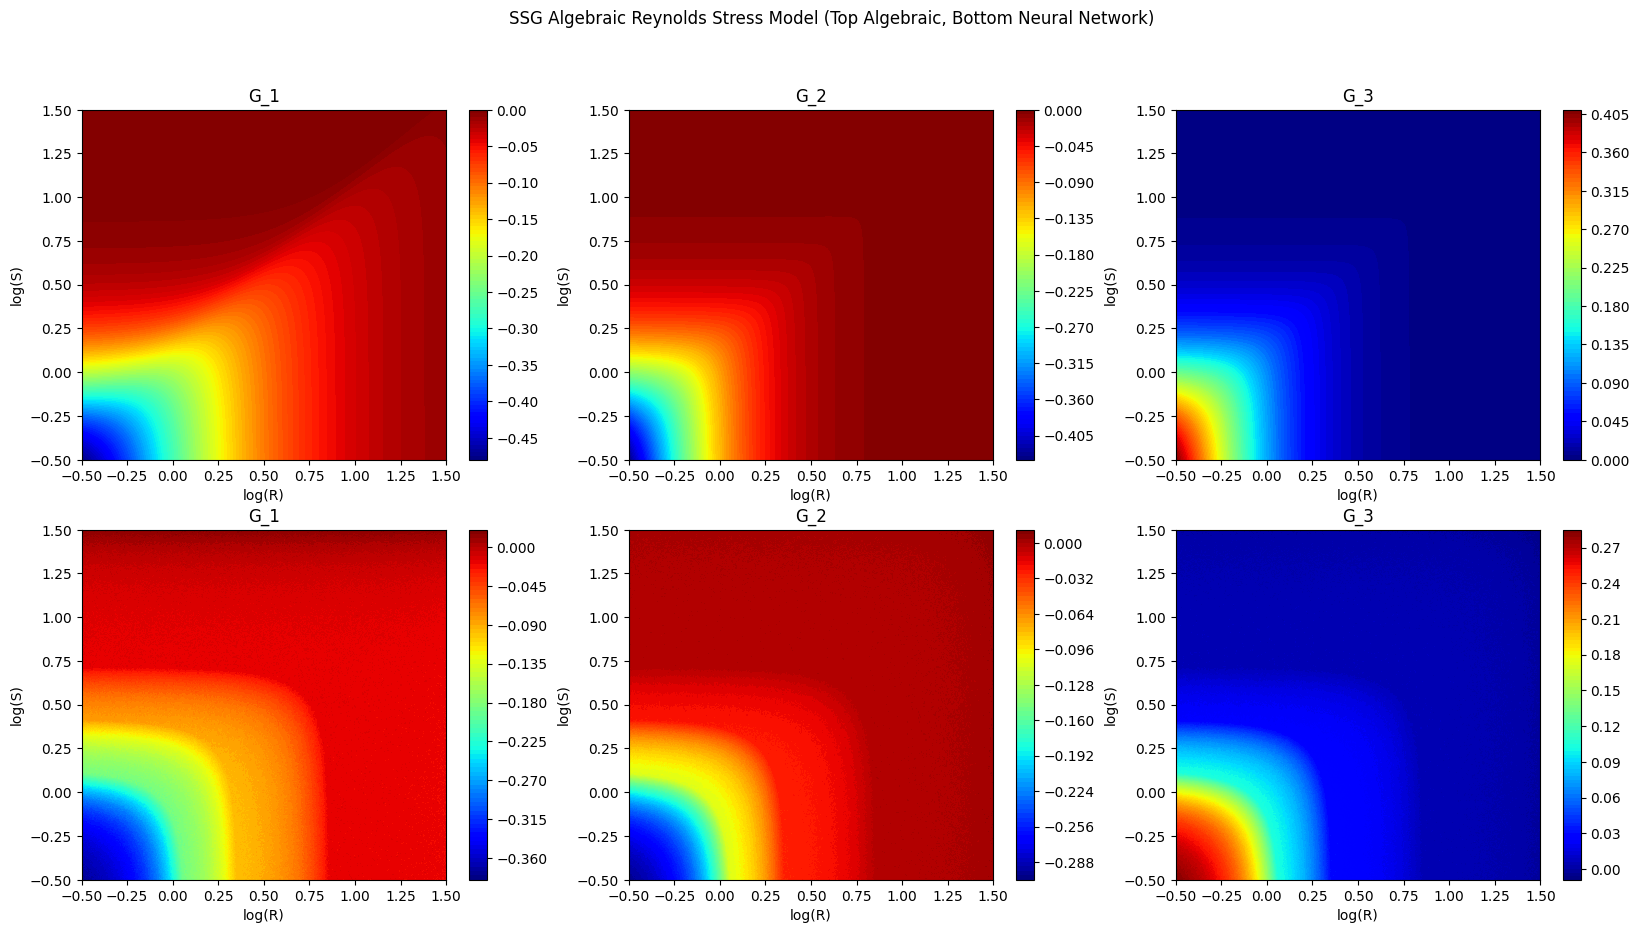

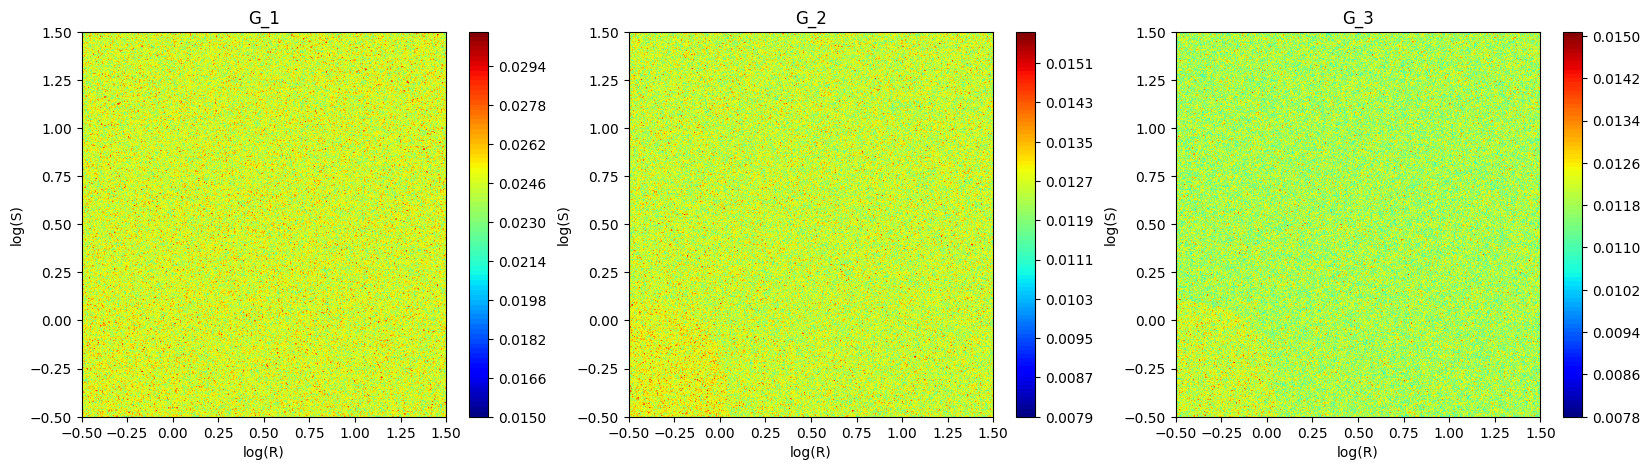

In [10]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]
etas = x_scaler.transform(etas)

predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))['obs']

for i in range(pred.shape[0]):
    pred[i] = torch.tensor(y_scaler.inverse_transform(pred[i].cpu().detach().numpy())).to(device)

pred_mean = torch.mean(pred, axis=0).detach().cpu()
pred_std = torch.std(pred, axis=0).detach().cpu()

del pred
del predictive
torch.cuda.empty_cache()

print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))